In [ ]:
!apt-get update
!pip install gym box2d-py gym[Box2D] pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [43.6 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.

In [ ]:
import base64
from collections import deque
import copy
import glob
import io
import itertools
import os
import random

import numpy as np

import torch
import torchvision
import torch as nn
import matplotlib.pyplot as plt


import gym
from gym.wrappers import Monitor

import PIL
from PIL import Image


from google.colab import drive
drive.mount('/content/gdrive')

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if gpu is available, use it
print(device)  # this should say cuda, if not turn on the gpu!


# Sentdex talks about replay here: 
# https://pythonprogramming.net/deep-q-learning-dqn-reinforcement-learning-python-tutorial/
REPLAY_MEMORY_SIZE = 10_000
LEARNING_RATE = 0.0004
N_EPOCHS = 5000
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.01
BATCH_SIZE = 64
N_BATCHS_PER_EPISODE = 3  # track generation is slow, so learn more per episode
RENDER = False
RENDER_EVERY = 25
SAVE_EVERY = 25
TARGET_UPDATE_EVERY = 100
DISCOUNT = 0.95    
FRAME_SKIP = 1
MIN_EXPLORATION_EPISODES = 0
neg_counter = 0

replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
epsilon = 1

episode_rewards = []
losses = []


possible_actions = np.array([[0.0, 1.0, 0.0], [1.0, 0.3, 0], [-1.0, 0.3, 0.0], [0.0, 0.0, 0.8]])
actionSpace = [0, 1, 2 , 3]

main_model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 6, kernel_size=(4, 4),stride=4),
        torch.nn.ReLU(),
        torch.nn.Conv2d(6, 24, kernel_size=(4, 4),stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(2, 2)),
        torch.nn.Flatten(),
        torch.nn.Linear(9*9*24, 1000),
        torch.nn.ReLU(),
        torch.nn.Linear(1000, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, len(actionSpace))
)

#print(main_model)

main_optimizer = torch.optim.SGD(main_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

main_optimizer.zero_grad()

if os.path.exists('/content/gdrive/My Drive/car_racing_model.pth'):
    print("Using Model!")
    main_model.load_state_dict(torch.load('/content/gdrive/My Drive/car_racing_model.pth'))

target_model = copy.deepcopy(main_model)

main_model.cuda()
target_model.cuda()


loss_func = torch.nn.MSELoss().cuda()

to_tensor = torchvision.transforms.ToTensor()

env = wrap_env(gym.make('CarRacing-v0'))


for episode in range(N_EPOCHS):
    done = False
    episode_reward = 0
    step_num = 0

    current_state = env.reset()
    #print(env.reset)

    while not done:
        if RENDER and episode % RENDER_EVERY == 0:
            env.render()

        if np.random.random() > epsilon:
            #print("Using Knowledge!")
            # true action
            state_image = PIL.Image.fromarray(current_state)
            state_image = PIL.ImageOps.grayscale(state_image) 
            state_image = state_image.crop((6, 12, 90, 96)) 
            state_image = PIL.ImageOps.equalize(state_image, mask=None)
            width, height = state_image.size
            #print(width,height)
            state_tensor = to_tensor(state_image).unsqueeze(0).cuda()
            #print(state_tensor.size())
            prediction = main_model(state_tensor)
            action_choice = torch.argmax(prediction)
            action = possible_actions[action_choice]
            
            if action_choice == 3:
              actionIndex = np.random.randint(0, 3)
              action = possible_actions[actionIndex]

        else:
            actionIndex = np.random.randint(0, 3)
            action = possible_actions[actionIndex]
        reward = 0
        for _ in range(FRAME_SKIP):
              
                  new_state, r, done, info = env.step(action)
            
                  reward += r

                  if reward > 0:
                    reward += 4

                  if reward == -100:
                    reward = 0

            
        episode_reward += reward

        if step_num < max(5, episode / 100):
          replay_memory.append((current_state, action, reward, new_state, done))

        step_num += 1

        current_state = new_state

    print(f'Episode {episode}: {episode_reward}')

    episode_rewards.append(episode_reward)


    # train our model
    if episode > 25:  
      for _ in range(N_BATCHS_PER_EPISODE):

        batch = random.sample(replay_memory, BATCH_SIZE)
        batch_current_states = torch.cat([to_tensor(PIL.ImageOps.grayscale(PIL.Image.fromarray(event[0])).crop((6, 12, 90, 96))).unsqueeze(0) for event in batch]).cuda()
        batch_current_qs = target_model(batch_current_states)

        batch_new_states = torch.cat([to_tensor(PIL.ImageOps.grayscale(PIL.Image.fromarray(event[3])).crop((6, 12, 90, 96))).unsqueeze(0) for event in batch]).cuda()
        batch_future_qs = target_model(batch_new_states)
        X = []
        y = []
        rewards = []

        for index, (current_state, action, reward, new_current_state, done) in enumerate(batch):

            #print(reward)

            if reward > 0:
              reward += 3

            if not done:

              max_future_q = torch.max(batch_future_qs[index])
              new_q = reward + DISCOUNT * max_future_q
            
            else:
   
              new_q = reward

            current_qs = batch_current_qs[index]
            current_qs[action] = new_q

            X.append(current_state)
            y.append(current_qs)
            rewards.append(reward)


        X = torch.cat([to_tensor(PIL.ImageOps.grayscale(PIL.Image.fromarray(x)).crop((6, 12, 90, 96))).unsqueeze(0) for x in X]).cuda()
        y = torch.cat([y.unsqueeze(0) for y in y]).cuda()

        if episode % 20 == 0:
          print(y)
          print(rewards)

        main_model.zero_grad()
        output = main_model(X).cuda()

        loss = loss_func(output, y).cuda()
        print(f'loss: {loss}')
        loss.backward()
        main_optimizer.step()

        losses.append(loss)
     
      if episode % TARGET_UPDATE_EVERY == 0:
          target_model.load_state_dict(main_model.state_dict())


      if episode > 100 and episode % 50 == 0:
        if sum(episode_rewards[-50:]) > sum(episode_rewards[-100:-50]):
          if epsilon > MIN_EPSILON and episode > MIN_EXPLORATION_EPISODES:
              epsilon -= 0.05
              epsilon = max(MIN_EPSILON, epsilon)
        else:
          epsilon += 0.025
      
      elif epsilon > MIN_EPSILON and episode > MIN_EXPLORATION_EPISODES:
          
          epsilon *= EPSILON_DECAY
          epsilon = max(MIN_EPSILON, epsilon)

      if episode % SAVE_EVERY == 0:
          torch.save(main_model.state_dict(), '/content/gdrive/My Drive/car_racing_model.pth')

      print (epsilon)



env.close()

Mounted at /content/gdrive
cuda
Using Model!


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1275..1598 -> 323-tiles track
Episode 0: 100.10621118012548
Track generation: 1200..1504 -> 304-tiles track
Episode 1: 99.70594059406051
Track generation: 1048..1314 -> 266-tiles track
Episode 2: 88.23018867924577
Track generation: 1128..1414 -> 286-tiles track
Episode 3: 391.5789473684026
Track generation: 980..1236 -> 256-tiles track
Episode 4: 78.19607843137774
Track generation: 1148..1439 -> 291-tiles track
Episode 5: 37.886206896551506
Track generation: 1093..1370 -> 277-tiles track
Episode 6: 92.99420289855215
Track generation: 1220..1529 -> 309-tiles track
Episode 7: 113.98181818181936
Track generation: 1221..1538 -> 317-tiles track
Episode 8: 154.34303797468473
Track generation: 1181..1483 -> 302-tiles track
Episode 9: 79.53388704319039
Track generation: 1088..1364 -> 276-tiles track
Episode 10: 124.36363636363768
Track generation: 1088..1364 -> 276-tiles track
Episode 11: 71.63636363636888
Track generation: 1123..1408 -> 285-tiles track
Episode 12: 131.943661

In [ ]:
show_video()

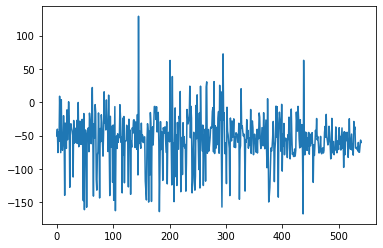

In [ ]:
plt.plot(episode_rewards)

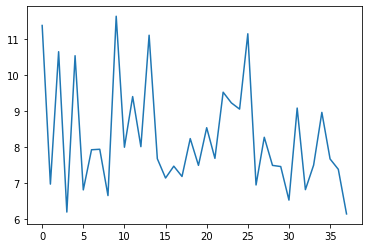

In [ ]:
plt.plot(losses)